In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


# Size stuff

In [10]:
betas = np.linspace(0,3,10)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(100,gen_data_ex,setup_shi,trials=100)
    reg,twostep, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,shi)
    results.append([reg,twostep,shi,boot1,boot2,boot3])


[1. 0. 0.] [1. 0. 0.] [0.96 0.   0.04]
[0.99 0.   0.01] [1. 0. 0.] [0.94 0.   0.06]
[0.91 0.01 0.08] [0.99 0.01 0.  ] [0.92 0.   0.08]
[0.89 0.   0.11] [1. 0. 0.] [0.94 0.   0.06]
[0.92 0.   0.08] [1. 0. 0.] [0.97 0.   0.03]
[0.87 0.   0.13] [1. 0. 0.] [0.97 0.   0.03]
[0.89 0.02 0.09] [0.91 0.02 0.07] [0.98 0.   0.02]
[0.87 0.03 0.1 ] [0.89 0.03 0.08] [0.97 0.   0.03]
[0.91 0.01 0.08] [0.91 0.01 0.08] [1. 0. 0.]
[0.95 0.01 0.04] [0.95 0.01 0.04] [1. 0. 0.]


(10, 6, 3)


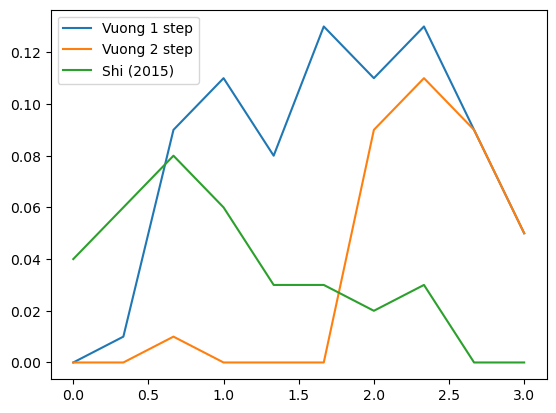

In [12]:
results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='Shi (2015)')
plt.plot(betas,1-results2[:,5,0],label='Bootstrap ND')
plt.legend()
plt.show()

# Power stuff

In [ ]:
def gen_data2(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs